# Toxic comment classification
## Exploration and preprocessing



## Instructions


## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Unzip
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.


In [1]:
#data 
import pandas as pd 
import numpy as np

#paths
import os

#save
import pickle

#plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# text processing 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


from wordcloud import WordCloud

import os





In [2]:
data_dir = '../data/'

## Step 1: Inspecting for missing values

In [3]:

train = pd.read_csv(data_dir+'train.csv') 

train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [4]:
test = pd.read_csv(data_dir+'/test.csv') 

test.head(1)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...


In [5]:
# There are not null entries
print(train.isnull().sum() , test.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 id              0
comment_text    0
dtype: int64


## Data Exploration

In [6]:
# Create class for non toxic comments
train['not_toxic'] = ( (train.iloc[:,2:].sum(axis=1)) == 0).astype('int')

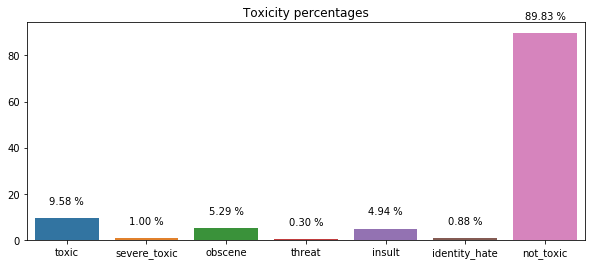

In [7]:
cols= train.iloc[:,2:]
cols_len= len(cols)
cols = cols.sum()/len(cols) *100

fig = plt.figure(figsize=(10,4))
ax = sns.barplot(cols.index, cols.values)
ax.set_title('Toxicity percentages')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 6,'{:1.2f} %'.format(height), ha="center") 
    
fig.savefig('../plots_tables/bar_plot.png')


**Insight:** There is an imbalance between toxic and non toxic comments.

**Consequnece:** We shall choose metrics to adress this imbalance

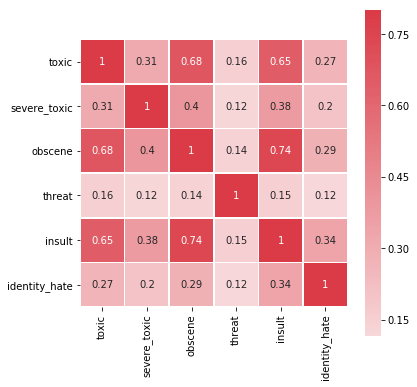

In [37]:
cmap = sns.diverging_palette(150, 10, as_cmap=True)
g = plt.figure(figsize=(6,6))
corr = train.iloc[:,2:8].corr()

sns.heatmap(corr,  cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, annot=True)

g.savefig('../plots_tables/corr.png')

**Insight:** Some correlations are are as low as -0.006, while The highest correlation, 0.75, corresponds to obsene and insult. Perhaps the most remarkable fact is that severe_toxicity is not extremely correlated with other variables like treat!

**Conclusion:** It is reasonable to assume target classes are independent.

# 2. WordCloud

In [9]:
stopwords_en = stopwords.words('english')

def cloud_maker(text, background = 'black', withStopwords=True):
    
    if withStopwords == True: _stw = stopwords_en
    else: _stw = []
    wordcloud = WordCloud(background_color = background, 
                stopwords = _stw)
    wordcloud.generate(text)
    return wordcloud


In [10]:
# wordcloud plot for subtypes of toxic comments
_labels = ['not_toxic', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plot_list=[]
for label in _labels:
    txt_label = train[train[label] == 1].comment_text.values
    txt_label = ' '.join(txt_label)
    if label == 'not_toxic': bcolor = 'white' 
    else: bcolor = 'black' 
    plot_list.append(cloud_maker(txt_label, background = bcolor) )

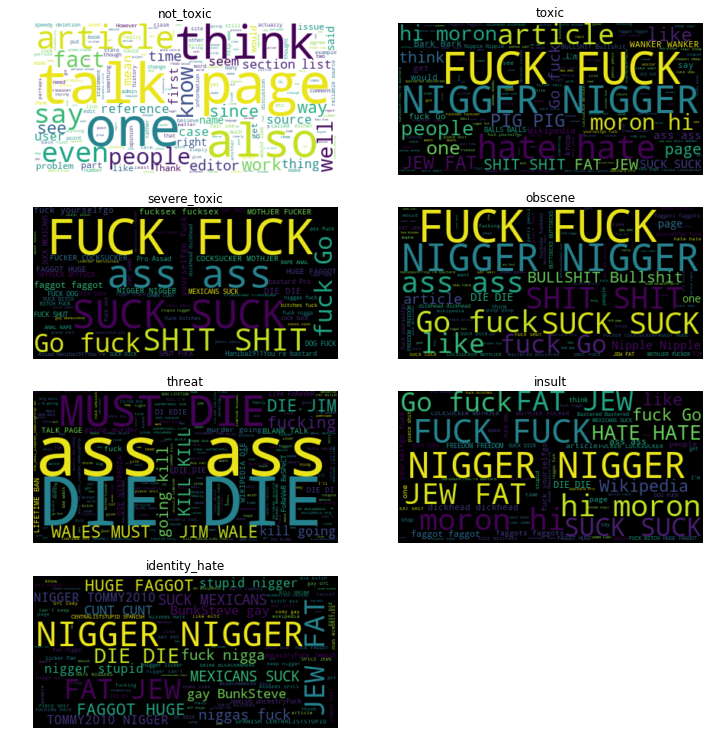

In [11]:
fig=plt.figure(figsize=(12,13))
columns = 2
rows = 4

for i in range(0, 7):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(plot_list[i].recolor(random_state=1234), 
              interpolation = 'bilinear')
    plt.gca().set_title(_labels[i])
    plt.axis("off")
fig.savefig('../plots_tables/clouds.png')

**Insight:** Hmmm so depressing 



# 2.- Preprocessing 

### Spliting comments from labels

In [12]:
comments = list(train.columns)[1]
labels = list(train.columns)[2:8]
comments, labels

('comment_text',
 ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

**Looking at the reviews, one finds comments which need a lot of preprocessing:**

In [13]:
rev=115
print('TRAIN\n')
print(train['comment_text'][rev][:120],'\n')
print('TEST\n')
print(test['comment_text'][rev][:120])

TRAIN

Also I think Vegetable Basket needs it's own Wikipedia page. 

TEST

== scholarly corroboration of folklore == 

 My understanding is that folklore can provide clues to history, medicine, a


The first step in processing the reviews is to make sure that any html tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis.

In [14]:
# We move the preprocessing step 
#special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
#replace_numbers=re.compile(r'\d+',re.IGNORECASE)
#def text_to_words_stemmed(text):
#    # remove special characters
#    text=special_character_removal.sub('',text)  
#    text=replace_numbers.sub('n', text)
#    text = text.lower().split()   
#    stops = set(stopwords.words("english"))
#    text = [w for w in text if not w in stops]
#    text = " ".join(text)
#    text = text.split()[:100]
#    stemmer = SnowballStemmer('english')
#    stemmed_words = [stemmer.stem(word) for word in text]    
#    return stemmed_words

In [15]:
import re

rep_numbers=re.compile(r'\d+',re.IGNORECASE) # Numbers
rep_special_chars= re.compile("[^\w']|_") # Special character but not apostrophes
def text_to_words(review):     
    text=rep_special_chars.sub(' ', review) # Remove special characters but apostrophes    
    text = rep_numbers.sub('n', text) # substitute all numbers  
    words = text.split() # Split string into words    
    return words #' '.join(words)

In [16]:
rev=7
print(train['comment_text'][rev],'\n AFTER: \n')
print(text_to_words(train['comment_text'][rev]))

Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned. 
 AFTER: 

['Your', 'vandalism', 'to', 'the', 'Matt', 'Shirvington', 'article', 'has', 'been', 'reverted', 'Please', "don't", 'do', 'it', 'again', 'or', 'you', 'will', 'be', 'banned']


In [17]:
test['comment_text'] = test.comment_text.apply(text_to_words)
train['comment_text'] = train.comment_text.apply(text_to_words)

In [18]:
train['length'] =train['comment_text'].apply(len)

In [19]:
(train['not_toxic'] == 1).sum()

143346

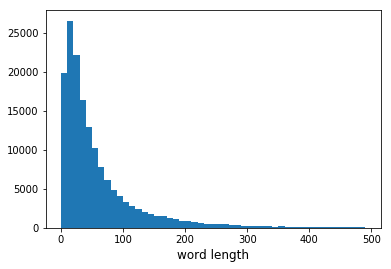

In [20]:


# histogram plot of the number of words each comment contains
fig_word_length = plt.figure()
plt.hist(train['length'],bins = np.arange(0,500,10))
plt.xlabel('word length',fontsize=12)
#plt.ylabel('number of comment_texts',fontsize=14)

# save the figure
fig_word_length.savefig('../plots_tables/word_length_hist.png')

**Insight:** There is a tail of much longer comments. The cut can be done around 100.

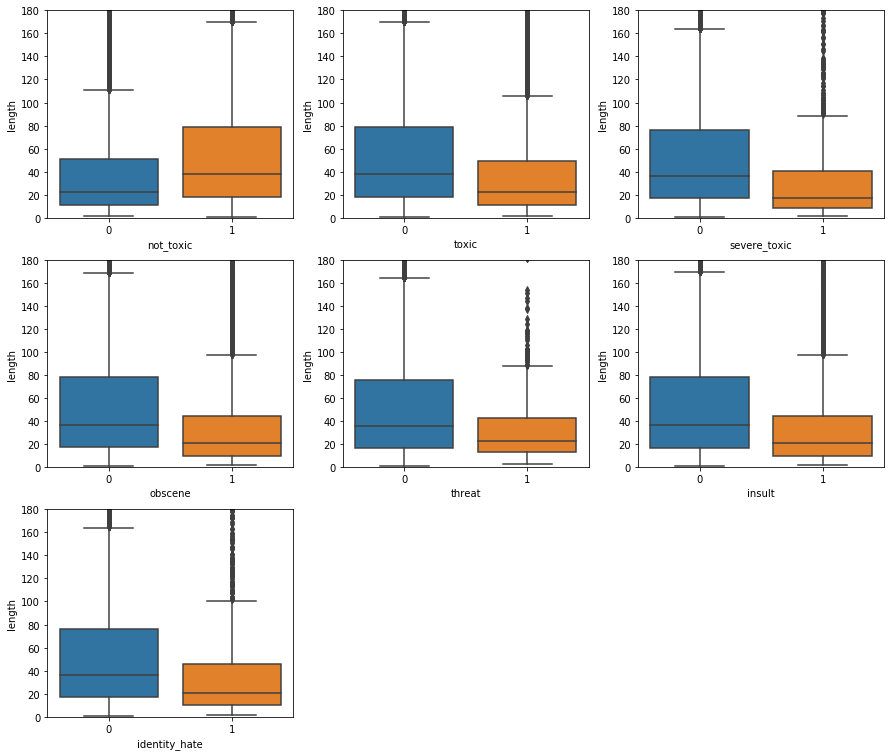

In [21]:
fig=plt.figure(figsize=(15,13))
columns = 3
rows = 3

for i in range(0, 7):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.ylim(0, 180)
    sns.catplot(y='length',x= _labels[i], data=train, kind='box', ax = ax)
    plt.close()
#fig.savefig('../plots_tables/catplots.png')

**Insight:** It seems that keeping at least 80 words its a sensible choice

In [22]:
train['comment_text'] = train['comment_text'].apply(lambda x: ' '.join(x))
test['comment_text'] = test['comment_text'].apply(lambda x: ' '.join(x))

In [23]:
from sklearn.utils import shuffle
final_train = train
final_train.drop(columns = ['not_toxic', 'length'], inplace = True);

In [24]:
final_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww He matches this background colour I'm se...,0,0,0,0,0,0
2,000113f07ec002fd,Hey man I'm really not trying to edit war It's...,0,0,0,0,0,0
3,0001b41b1c6bb37e,More I can't make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0


In [25]:
final_train.to_csv(data_dir+'train_preprocessed.csv')
test.to_csv(data_dir+'test_preprocessed.csv')

In [26]:
final_train.to_json(data_dir+'train_preprocessed.json', orient='records', lines=True)
test.to_json(data_dir+'train_preprocessed.json', orient='records', lines=True)

#### TODO: Use functions below to undersample / oversample to address imbalance. For now we shall just keep all data

In [27]:
toxic_labels = ['toxic','severe_toxic','obscene','insult','identity_hate'] 

In [28]:
non_toxic_train = train[train[toxic_labels].sum(axis=1)== 0 ]
toxic_train = train[train[toxic_labels].sum(axis=1) != 0 ]

In [29]:
len(toxic_train)

16203

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_1, X_2 = train_test_split(non_toxic_train, test_size=0.000000001, random_state=42)

In [32]:
len(X_1)/len(toxic_train)

8.848176263654878